In [1]:
import torch
from torch import nn
import pretrainedmodels

from utils.train import train
from utils.evaluation import evaluation
from utils.loader import get_loader, get_image_list
from utils.losses import CostSensitiveRegularizedLoss

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# hyper params
num_of_class = 102
learning_rate = 1e-04
batch_size = 128
input_size = 224
device = torch.device("cuda")
test_size = 0.2
train_size = 0.7
val_size = 0.1
directoryAgeDB = 'AgeDB/'

In [3]:
def findAge(image_list):
    listofzeros = [0] * 102
    same_age = [i for i in range(0, 102)]
    age_number = dict(zip(same_age, listofzeros))
    sum = 0

    for i in range(len(image_list)):

        if image_list[i]['age'] in age_number:
            age_number[image_list[i]['age']] += 1
            sum += 1

    print(sum)
    return dict(age_number)


In [4]:
train_image_list, test_image_list, validate_image_list = get_image_list(
    train_size=train_size, 
    test_size=test_size, 
    val_size=val_size, 
    directory=directoryAgeDB,
)

train_loader, test_loader, validation_loader = get_loader(
    input_size=input_size,
    train_image_list=train_image_list,
    test_image_list=test_image_list, 
    validate_image_list=validate_image_list, 
    batch_size=batch_size,
    train_augment=3,
)

  0%|          | 0/11541 [00:00<?, ?it/s]

Train Set Length:  34623
Test Set Length:  3298
Validation Set Length:  1649
Total:  39570


In [5]:
ResNet18 = pretrainedmodels.resnet18(pretrained='imagenet')
ResNet18.last_linear = nn.Linear(
    in_features=ResNet18.last_linear.in_features, 
    out_features=num_of_class, 
    bias=False
)
resnetModel = ResNet18.to(device)

In [6]:
resnet1 = pretrainedmodels.resnet18(pretrained='imagenet')
resnet1.last_linear = nn.Linear(
    in_features=resnet1.last_linear.in_features, 
    out_features=num_of_class, 
    bias=False
)
resnet2 = pretrainedmodels.resnet18(pretrained='imagenet')
resnet2.last_linear = nn.Linear(
    in_features=resnet2.last_linear.in_features, 
    out_features=num_of_class, 
    bias=False
)
resnet1 = resnet1.to(device)
resnet2 = resnet2.to(device)

In [7]:
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet1.parameters(), lr=learning_rate, weight_decay=1e-1)
model_name = 'baseline-aug.pth'

Epoch: 1/5, Train Loss: 3.9415155266483772,  Validation Loss: 3.800230154624352
Validation Loss Decreased(inf ---> 3.800230154624352)
Epoch: 2/5, Train Loss: 3.483887313476788,  Validation Loss: 3.7592983612647424
Validation Loss Decreased(3.800230154624352 ---> 3.7592983612647424)
Epoch: 3/5, Train Loss: 3.3656764531927355,  Validation Loss: 3.780012607574463
Epoch: 4/5, Train Loss: 3.3038167988682146,  Validation Loss: 3.7619671454796424
Epoch: 5/5, Train Loss: 3.260275715831461,  Validation Loss: 3.803414509846614


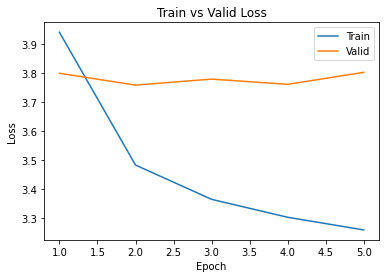

In [8]:
train(resnet1, optimizer, criteria, train_loader, validation_loader, num_of_epoch=5, model_name=model_name)

In [9]:
resnet1.load_state_dict(torch.load(model_name))
loss_per_class = evaluation(resnet1, test_loader)
_ = evaluation(resnet1, train_loader)

Mean Absolute Error: 7.932506938934326
Minimum: 0.0, Maximum: 55.0, Median: 6.0
Mean Absolute Error: 6.174662635803223
Minimum: 0.0, Maximum: 63.0, Median: 5.0


In [10]:
sample_per_class = findAge(test_image_list)
print('Age: Test Sample: Loss')
for i in range(1, 102):
    if sample_per_class[i] == 0:
        print(i,' No Sample')
    else:
        print(i,':', sample_per_class[i],':', format(loss_per_class[i].item()/sample_per_class[i],'.2f'))

3298
Age: Test Sample: Loss
1 : 1 : 40.00
2  No Sample
3 : 2 : 29.50
4 : 1 : 34.00
5 : 1 : 30.00
6 : 2 : 20.00
7 : 2 : 27.00
8 : 2 : 17.00
9 : 1 : 26.00
10 : 3 : 13.33
11 : 4 : 17.25
12 : 3 : 8.33
13 : 4 : 15.50
14 : 5 : 14.00
15 : 9 : 12.33
16 : 10 : 10.20
17 : 16 : 10.00
18 : 24 : 7.33
19 : 22 : 10.64
20 : 32 : 8.47
21 : 33 : 9.06
22 : 37 : 8.57
23 : 42 : 6.93
24 : 52 : 6.65
25 : 57 : 5.32
26 : 55 : 5.07
27 : 61 : 5.66
28 : 69 : 4.62
29 : 62 : 5.84
30 : 77 : 4.97
31 : 63 : 6.79
32 : 75 : 5.67
33 : 67 : 5.16
34 : 72 : 6.33
35 : 82 : 5.91
36 : 69 : 5.91
37 : 74 : 7.45
38 : 76 : 6.47
39 : 64 : 6.42
40 : 77 : 7.42
41 : 64 : 6.80
42 : 71 : 8.59
43 : 65 : 8.74
44 : 56 : 8.34
45 : 68 : 8.75
46 : 57 : 8.68
47 : 58 : 7.71
48 : 62 : 8.34
49 : 53 : 9.77
50 : 63 : 8.79
51 : 57 : 9.35
52 : 62 : 8.00
53 : 50 : 10.56
54 : 51 : 7.43
55 : 59 : 10.68
56 : 45 : 8.29
57 : 49 : 9.88
58 : 49 : 8.22
59 : 43 : 7.40
60 : 49 : 7.18
61 : 41 : 8.78
62 : 48 : 8.73
63 : 44 : 9.23
64 : 39 : 7.03
65 : 46 : 7.04
66 

  0%|          | 0/11541 [00:00<?, ?it/s]

Train Set Length:  11541
Test Set Length:  3298
Validation Set Length:  1649
Total:  16488
Epoch: 1/5, Train Loss: 4.29024434875656,  Validation Loss: 4.051656136145959
Validation Loss Decreased(inf ---> 4.051656136145959)
Epoch: 2/5, Train Loss: 3.8197100581703607,  Validation Loss: 3.8792674724872294
Validation Loss Decreased(4.051656136145959 ---> 3.8792674724872294)
Epoch: 3/5, Train Loss: 3.543857244344858,  Validation Loss: 3.8180128060854397
Validation Loss Decreased(3.8792674724872294 ---> 3.8180128060854397)
Epoch: 4/5, Train Loss: 3.260190251109364,  Validation Loss: 3.8348507697765646
Epoch: 5/5, Train Loss: 2.920554837027749,  Validation Loss: 3.923731492115901


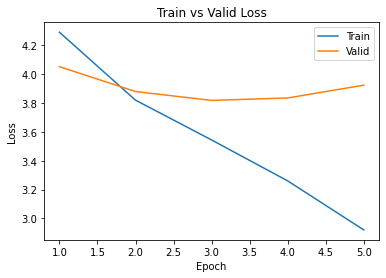

In [11]:
train_loader, test_loader, validation_loader = get_loader(
    input_size=input_size,
    train_image_list=train_image_list,
    test_image_list=test_image_list, 
    validate_image_list=validate_image_list, 
    batch_size=batch_size,
    train_augment=1,
)
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet2.parameters(), lr=learning_rate, weight_decay=1e-1)
model_name = 'baseline.pth'
train(resnet2, optimizer, criteria, train_loader, validation_loader, num_of_epoch=5, model_name=model_name)

In [12]:
resnet2.load_state_dict(torch.load(model_name))
loss_per_class = evaluation(resnet2, test_loader)
_ = evaluation(resnet2, train_loader)

Mean Absolute Error: 8.157064437866211
Minimum: 0.0, Maximum: 57.0, Median: 7.0
Mean Absolute Error: 6.032085704803467
Minimum: 0.0, Maximum: 56.0, Median: 4.0


In [13]:
sample_per_class = findAge(test_image_list)
print('Age: Test Sample: Loss')
for i in range(1, 102):
    if sample_per_class[i] == 0:
        print(i,' No Sample')
    else:
        print(i,':', sample_per_class[i],':', format(loss_per_class[i].item()/sample_per_class[i],'.2f'))

3298
Age: Test Sample: Loss
1 : 1 : 50.00
2  No Sample
3 : 2 : 40.00
4 : 1 : 26.00
5 : 1 : 30.00
6 : 2 : 19.00
7 : 2 : 34.50
8 : 2 : 30.00
9 : 1 : 14.00
10 : 3 : 17.33
11 : 4 : 24.75
12 : 3 : 19.33
13 : 4 : 15.50
14 : 5 : 15.20
15 : 9 : 14.89
16 : 10 : 14.00
17 : 16 : 12.06
18 : 24 : 9.08
19 : 22 : 14.23
20 : 32 : 11.12
21 : 33 : 12.33
22 : 37 : 10.27
23 : 42 : 7.38
24 : 52 : 8.77
25 : 57 : 7.04
26 : 55 : 7.85
27 : 61 : 8.36
28 : 69 : 6.62
29 : 62 : 6.90
30 : 77 : 7.61
31 : 63 : 6.81
32 : 75 : 6.04
33 : 67 : 5.46
34 : 72 : 6.92
35 : 82 : 7.48
36 : 69 : 6.70
37 : 74 : 6.88
38 : 76 : 6.51
39 : 64 : 6.48
40 : 77 : 6.86
41 : 64 : 7.03
42 : 71 : 7.51
43 : 65 : 7.17
44 : 56 : 7.09
45 : 68 : 7.46
46 : 57 : 8.19
47 : 58 : 6.60
48 : 62 : 7.74
49 : 53 : 7.75
50 : 63 : 8.62
51 : 57 : 10.32
52 : 62 : 7.15
53 : 50 : 9.94
54 : 51 : 8.08
55 : 59 : 8.93
56 : 45 : 7.67
57 : 49 : 10.04
58 : 49 : 8.47
59 : 43 : 8.47
60 : 49 : 8.94
61 : 41 : 7.88
62 : 48 : 9.27
63 : 44 : 8.09
64 : 39 : 7.95
65 : 46 : 6.07